In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from itertools import product
from scipy.integrate import quad

In [ ]:
# Constants
r = 0.01  #Interest rate
T = 1     #Time to maturity
K = 1     #Strike price
n = 2     #Nr of stocks
S0 = 1    #Price of stock j at t=0
sigma = 1 #volatility (GBM)

In [ ]:
grid_size = 64
a = -5
b = 5

# 1-D grids
x1_grid = np.linspace(a, b, grid_size)
x2_grid = x1_grid

# N-D grid
mesh = np.meshgrid(x1_grid, x2_grid, indexing='ij')
x_grid = np.stack(mesh, axis=-1).reshape(-1, n)

In [ ]:
# Gaussian RV with zero mean and covariance with the diagonal set to T and everything else set to 0.5T
mu = np.zeros(n)
cov = np.ones((n,n)) * 0.5 * T + np.eye(n) * 0.5 * T
#samples = np.random.multivariate_normal(mean=mu, cov=cov, size = 32 ** n)

# f(x1, x2, ..., xn) samples on grid
mvn = multivariate_normal(mean=mu, cov=cov, seed=42)
f_vals = mvn.pdf(x_grid)

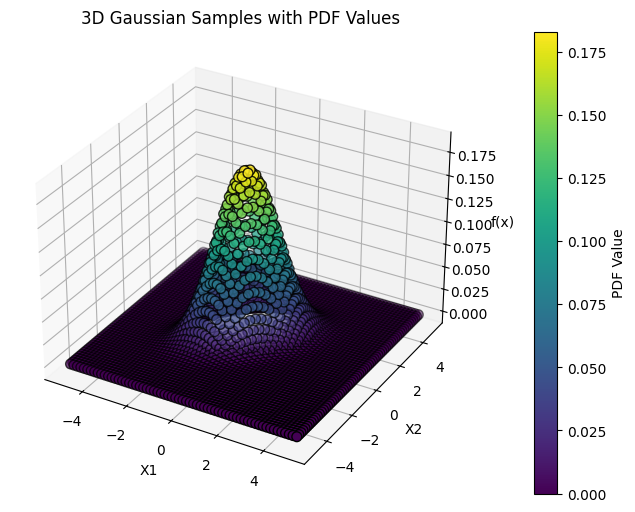

In [ ]:
if n == 2:
  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111, projection='3d')
  scatter = ax.scatter(x_grid[:, 0], x_grid[:, 1], f_vals, c=f_vals, cmap='viridis', s=50, edgecolor='k')

  # Colorbar and labels
  cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
  cbar.set_label('PDF Value')
  ax.set_title('3D Gaussian Samples with PDF Values')
  ax.set_xlabel('X1')
  ax.set_ylabel('X2')
  ax.set_zlabel('f(x)')
  plt.show()

In [ ]:
def Phi(w: np.array):
  return np.exp(-w.T @ cov @ w)

In [ ]:
# Number of cosine terms
Nc = 16;
# all combinations for (k0, k1, k2, ..., kn-1)
combinations = list(product(range(Nc), repeat=n))

In [ ]:
norm_factor = 2 / ((b-a)**n)
q = np.pi / (b-a)

# (ε2, ε3, ..., εn) combinations where εk = ±1
eps_combinations = list(product([1, -1], repeat=n-1))

# Cosine expansion coeffecients calculation
A = np.zeros((Nc,) * n)
for k in combinations:
    k_array = np.array(k) # Convert tuple to array
    k1 = k_array[0]
    k_rest = k_array[1:]

    # calculate the sum Σ_ε by summing over
    # ε = (ε2, ε3, ... , εn) tuples
    tmp = 0
    for eps in eps_combinations:
      #ε2, ε3, ... , εn
      eps_array = np.array(eps)

      # Cosine argument: q * a * (k1 + Σ(ε2*k2 + ε3*k3 + ...))
      arg = q * a * (k_array[0] + np.sum(eps_array * k_rest))

      # Sum contributions from ε combinations
      w = q * np.array([k1] + list(eps_array * k_rest))
      tmp += Phi(w) * np.cos(arg)

    # For ki = 0, half weights are used in the sum
    n_nonzero = np.count_nonzero(k_array)
    n_zero = n - n_nonzero
    # Compute the normalization factor; 1 if not any zeros
    half_factor = 1 / 2**n_zero

    A[k] = n * half_factor * norm_factor * tmp;

In [ ]:
class ChFunEstimator:
  def __init__(self, Ak: np.array, a, b):
    """
      Initialize the characteristic function estimator.
      Parameters:
        - Ak (np.ndarray): The cosine expansion coefficients matrix.
    """
    self.A = A
    self.Nc = Ak.shape[0]
    self.n = Ak.ndim
    self.a = a
    self.b = b
    self.q = np.pi / (b-a)

  def show_info(self):
    print(self.Nc, self.n)

  def pdf(self, x):

    x = np.atleast_2d(x)  # Ensure x is 2D (num_points, n)
    n_samples = x.shape[0]
    results = np.zeros(n_samples)  # init

    f = 0
    for k in combinations:
      k_array = np.array(k)

      # cosine product
      cos_prod = np.prod(np.cos(k_array * self.q * (x - self.a)), axis=1)

      # Contribution to Cosine Expansion
      f +=  self.A[tuple(k)] * cos_prod

    #f = n * f
    return f

In [ ]:
mvn_estimator = ChFunEstimator(A)
fhat_vals = mvn_estimator.pdf(x_grid)

In [ ]:
print(mvn.pdf(np.zeros(n)))
print(mvn_estimator.pdf(np.zeros(n)))

0.1837762984739307
[0.1837763]


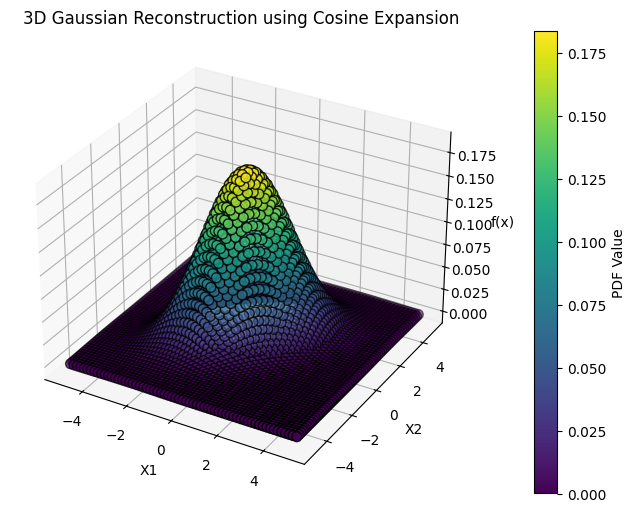

In [ ]:
if n==2:
  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111, projection='3d')
  scatter = ax.scatter(x_grid[:, 0], x_grid[:, 1], fhat_vals, c=fhat_vals, cmap='viridis', s=50, edgecolor='k')

  # Colorbar and labels
  cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
  cbar.set_label('PDF Value')
  ax.set_title('3D Gaussian Reconstruction using Cosine Expansion')
  ax.set_xlabel('X1')
  ax.set_ylabel('X2')
  ax.set_zlabel('f(x)')
  plt.show()

-----METRICS-----
Maximum Error: 0.0459
Mean Absolute Error (MAE): 0.0097
Mean Squared Error (MSE): 0.0003
Root Mean Squared Error (RMSE): 0.0172

-----NORMALIZED METRICS-----
Normalization Factor (std of f_vals): 0.0282
Normalized Maximum Error (NMaxError): 1.6279
Normalized Mean Absolute Error (NMAE): 0.3436
Normalized Mean Squared Error (NMSE): 0.0105
Normalized Root Mean Squared Error (NRMSE): 0.6105


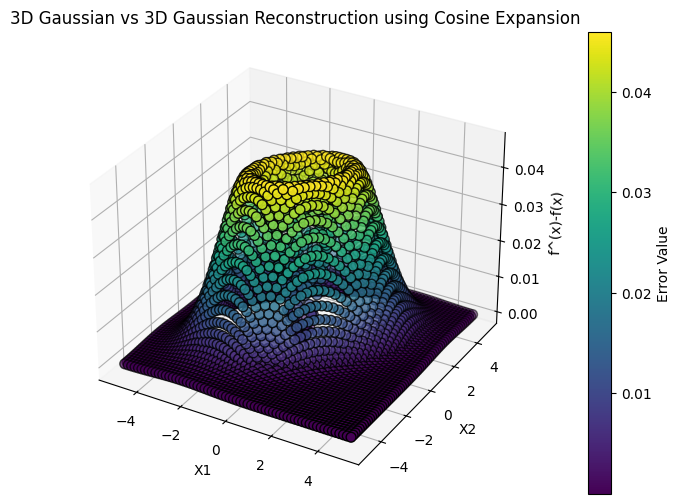

In [ ]:
# Metrics
err = f_vals - fhat_vals
max_error = np.max(abs(err))
mae = np.mean(abs(err))
mse = np.mean((err)**2)
rmse = np.sqrt(mse)
print("-----METRICS-----")
print(f"Maximum Error: {max_error:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Normalized Metrics
norm_factor = np.std(f_vals)
nmax_error = max_error / norm_factor
nmae = mae / norm_factor
nmse = mse / norm_factor
nrmse = rmse / norm_factor
print("\n-----NORMALIZED METRICS-----")
print(f"Normalization Factor (std of f_vals): {norm_factor:.4f}")
print(f"Normalized Maximum Error (NMaxError): {nmax_error:.4f}")
print(f"Normalized Mean Absolute Error (NMAE): {nmae:.4f}")
print(f"Normalized Mean Squared Error (NMSE): {nmse:.4f}")
print(f"Normalized Root Mean Squared Error (NRMSE): {nrmse:.4f}")

if n==2:
  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111, projection='3d')
  scatter = ax.scatter(x_grid[:, 0], x_grid[:, 1], fhat_vals-f_vals, c=fhat_vals-f_vals, cmap='viridis', s=50, edgecolor='k')

  # Colorbar and labels
  cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
  cbar.set_label('Error Value')
  ax.set_title('3D Gaussian vs 3D Gaussian Reconstruction using Cosine Expansion')
  ax.set_xlabel('X1')
  ax.set_ylabel('X2')
  ax.set_zlabel('f^(x)-f(x)')
  plt.show()

In [ ]:
# Monte Carlo Pricing
Nmc = 50000
Pmc = np.zeros(Nmc)

Wmc = np.random.multivariate_normal(mean=mu, cov=cov, size = Nmc)
Smc = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * Wmc)

# Mean Basket
Bmc = np.mean(Smc, axis=1)
# Option (put) Payoff
Pmc = np.maximum(K-Bmc, 0)
# Discounted
Pmc = Pmc * np.exp(-r * T)

Mean of discounted payoffs: 0.334
Standard deviation of discounted payoffs: 0.308
Standard error of the mean: 0.001


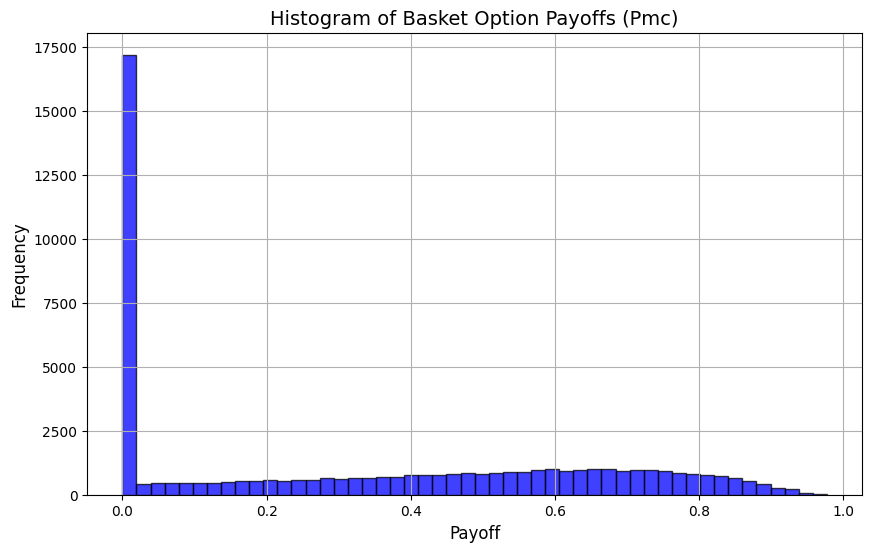

In [ ]:
# Metrics
mean_payoff = np.mean(Pmc)  # Mean of payoffs
std_payoff = np.std(Pmc)    # Standard deviation of payoffs
stderr_mean = std_payoff / np.sqrt(Nmc)  # Standard error of the mean

# Print results
print(f"Mean of discounted payoffs: {mean_payoff:.3f}")
print(f"Standard deviation of discounted payoffs: {std_payoff:.3f}")
print(f"Standard error of the mean: {stderr_mean:.3f}")

# Plot histogram of payoffs
plt.figure(figsize=(10, 6))
plt.hist(Pmc, bins=50, alpha=0.75, color='blue', edgecolor='black')
plt.title('Histogram of Basket Option Payoffs (Pmc)', fontsize=14)
plt.xlabel('Payoff', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
def I_real(w_j, t, N, k_j, a, b):
    exponent = np.exp(-0.49 + w_j)
    return np.cos(t / N * exponent) * np.cos(k_j * np.pi * (w_j - a) / (b - a))

def I_imag(w_j, t, N, k_j, a, b):
    exponent = np.exp(-0.49 + w_j)
    return np.sin(t / N * exponent) * np.cos(k_j * np.pi * (w_j - a) / (b - a))

def I(t, N, k_j, a, b):
    # Integrate real part
    real_part, _ = quad(I_real, a, b, args=(t, N, k_j, a, b))
    # Integrate imaginary part
    imag_part, _ = quad(I_imag, a, b, args=(t, N, k_j, a, b))
    # Combine real and imaginary parts
    return real_part + 1j * imag_part

In [ ]:
class BasketChFun:
  def __init__(self, Ak: np.array, a, b):
    self.A = A
    self.Nc = Ak.shape[0]
    self.n = Ak.ndim
    self.N = n
    self.a = a
    self.b = b

  def show_info(self):
    print(self.Nc, self.n)

  def I_real(self, w_j, t, N, k_j, a, b):
    """Real part of the integrand."""
    exponent = np.exp(-0.49 + w_j)
    return np.cos(t / N * exponent) * np.cos(k_j * np.pi * (w_j - a) / (b - a))

  def I_imag(self, w_j, t, N, k_j, a, b):
    """Imaginary part of the integrand."""
    exponent = np.exp(-0.49 + w_j)
    return np.sin(t / N * exponent) * np.cos(k_j * np.pi * (w_j - a) / (b - a))

  def I(self, t, k_j):
    """Compute the complex-valued integral."""
    # Integrate real part
    real_part, _ = quad(I_real, self.a, self.b, args=(t, self.N, k_j, self.a, self.b))
    # Integrate imaginary part
    imag_part, _ = quad(I_imag, self.a, self.b, args=(t, self.N, k_j, self.a, self.b))
    # Combine real and imaginary parts
    return real_part + 1j * imag_part

  def phi(self, t):

    Ij = np.zeros(Nc, dtype=complex)
    for j in range(Nc):
      Ij[j] = self.I(t,j)

    f = 0;
    for k in combinations:
      k_array = np.array(k)

      integral_prod = np.prod([Ij[k_i] for k_i in k_array])

      # Contribution to Cosine Expansion
      f +=  self.A[k] * integral_prod

    return f


In [ ]:
basket_ch = BasketChFun(A, a, b)

In [ ]:
Nc_B = 64
aB = 0
bB = 1
Fk = np.zeros(Nc_B)

# i = 0 -> half weight
z = basket_ch.phi(t=0.0)
Fk[0] = 1/2 * 2/(bB-aB) * z.real

# i > 0
for k in range(1, Nc_B):
  z = basket_ch.phi( k * np.pi / (bB-aB) )
  Fk[k] = 2 / (bB-aB) * z.real

<ipython-input-93-d1847d6933e3>:26: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  real_part, _ = quad(I_real, self.a, self.b, args=(t, self.N, k_j, self.a, self.b))
<ipython-input-93-d1847d6933e3>:28: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  o

In [ ]:
kB = np.arange(0,Nc_B)
Vk = np.zeros(Nc_B)
Vk[0] = 1/2 * (2*K-1)
Vk[1:]= (1 - (-1)**kB[1:])/(np.pi**2 * kB[1:]**2)

In [ ]:
Pcos = 1/2*(bB-aB)* np.dot(Fk,Vk)
# discounted
Pcos = np.exp(-r*T) * Pcos

In [ ]:
Pcos

0.5255863752995311